# Generate lookup table for petal-dependant offsets

In [1]:
import numpy
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
print(mpl.get_backend())
from sklearn.neighbors import KDTree

from astropy.io import fits
from astropy.table import join
from astropy import units as u

import desimodel.focalplane.geometry as geom
from desisim.templates import STD

module://ipykernel.pylab.backend_inline


/home/tyapici/anaconda/anaconda3/envs/dithering/lib/python3.6/site-packages/desispec-0.28.0.dev3299-py3.6.egg/desispec/maskbits.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """)


We load the lookup table from $\texttt{desimodel}$. Since we want to know which fiber is on which petal, we generate a KDTree based on the desimodel table.

In [2]:
mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

In [3]:
tbl = geom.load_deviceloc()
x_tbl = tbl['X']; y_tbl = tbl['Y']; petal_tbl = tbl['PETAL']
tree = KDTree(list(zip(x_tbl,y_tbl)), leaf_size=4)

We load the test tile (tile 58060) for the focal coordinates. The flux values are also converted to the respective magnitudes.

In [4]:
orig_hdu = fits.open('../../../dithering-results/GAIA_tiles/tile-058060.fits')
orig_data = orig_hdu[1].data

proc_hdu = fits.open('../../../dithering-results/GAIA_tiles/tile58060_rot0.01_dithertest.fits')
proc_data = proc_hdu[1].data

# Join the offset and original tables.
joined_data = join(orig_data, proc_data, keys=['TARGETID', 'FIBER', 'LOCATION'])

# Add magnitude columns.
for band in ['G', 'R', 'Z']:
    joined_data['MAG_{}'.format(band)] = 22.5 - 2.5*numpy.log10(joined_data['FLUX_{}'.format(band)])

This is where the magic happens. Using the $\bf KDTree$, we find which fiber is on which petal. This information is later used to input the petal-dependant offsets. To assure that we get at least one fiber from the KDTree, we use a distance of 8 mm. This distance is arbitrarily chosen but returns at least one fiber from the query_radius method. When going over the devices (which are actually fiber ids), we only select the first one (since query is set to sort the results with respect to their distances).

In [5]:
x, y = joined_data['DESIGN_X']*u.mm, joined_data['DESIGN_Y']*u.mm
flux_r = joined_data['FLUX_R']
mag_r = joined_data['MAG_R']
fiber_coordinates = list(zip(x.value, y.value))
devices, distances = tree.query_radius(numpy.asarray(fiber_coordinates).reshape(len(x),2), r=8, sort_results=True, return_distance=True)
petals = numpy.zeros(len(devices), dtype=int)
for i, device in enumerate(devices):
    petals[i] = petal_tbl[device[0]]

Here we show a little statistics about the petal and assigned sources

In [6]:
for i in range(10):
    print("For petal {}, we have {} fibers assigned".format(i, len(petals[petals==i])))

For petal 0, we have 100 fibers assigned
For petal 1, we have 87 fibers assigned
For petal 2, we have 99 fibers assigned
For petal 3, we have 101 fibers assigned
For petal 4, we have 107 fibers assigned
For petal 5, we have 91 fibers assigned
For petal 6, we have 110 fibers assigned
For petal 7, we have 111 fibers assigned
For petal 8, we have 90 fibers assigned
For petal 9, we have 81 fibers assigned


Now that we know all the fibers and their respective petals, we generate random offset per petal. The parameter named, offset_amplitude, defines the maximum and minimum range for the random offsets that will be generated. As an example, we chose 20um.

In [7]:
offset_amplitude = 20.
random_x = numpy.random.uniform(low=-offset_amplitude, high=offset_amplitude, size=10)
random_y = numpy.random.uniform(low=-offset_amplitude, high=offset_amplitude, size=10)
dx = [random_x[curr_petal] for curr_petal in petals]*u.um
dy = [random_y[curr_petal] for curr_petal in petals]*u.um

Here, we plot the generated offsets on the petals. It is also a good sanity check.

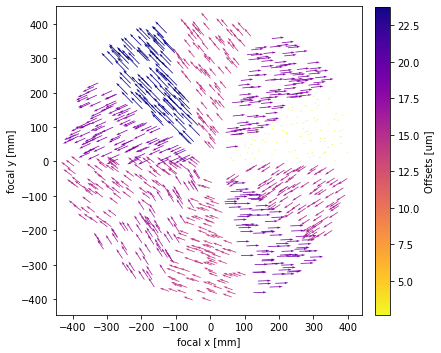

In [8]:
fig = plt.figure(figsize=(6,6))
plt.quiver(x.value, y.value, dx.value, dy.value, numpy.sqrt(dx.value**2+dy.value**2), scale=.5, units='xy', cmap=mpl.cm.plasma_r)
plt.gca().set_aspect(1)
plt.xlabel(xlabel="focal x [mm]")
plt.ylabel(ylabel="focal y [mm]")
plt.colorbar(fraction=0.046, pad=0.04, label="Offsets [um]")
plt.show()

We need to generate star spectra for the fibers. We use $\texttt{desisim}$ for this.

In [9]:
starmaker = STD(minwave=3550., maxwave=9850.)
nspec = len(mag_r)
flux, wave, meta, objmeta = starmaker.make_templates(mag=mag_r, nmodel=nspec, south=False,
                                                     seed=numpy.random.randint(1, numpy.iinfo(numpy.int32).max))

INFO:io.py:956:read_basis_templates: Reading /home/tyapici/anaconda/anaconda3/envs/dithering/desi/spectro/templates/basis_templates/v3.1/star_templates_v3.1.fits


/home/tyapici/anaconda/anaconda3/envs/dithering/lib/python3.6/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


# Save the file to use in the simulations

In [10]:
x_pos = []; y_pos = [];
x_offsets = []; y_offsets = [];
wlens = []; fluxes = [];
mags = [];

for i, _ in enumerate(joined_data):
    x_pos.append(joined_data['DESIGN_X'][i])
    y_pos.append(joined_data['DESIGN_Y'][i])
    x_offsets.append(dx[i].value)
    y_offsets.append(dy[i].value)
    mags.append([joined_data['MAG_G'], joined_data['MAG_R'], joined_data['MAG_Z']])
    fluxes.append(flux[i].T.reshape(1, -1)[0])
    wlens.append(wave[i].reshape(1, -1)[0])
    if i % 100 == 0:
        print("{} out of {} done".format(i, len(joined_data)-1))
print("{} out of {} done".format(i, len(joined_data)-1))
        
numpy.savez('tabled_values_petal-dependent-offsets.npz',
            x_pos=x_pos, y_pos=y_pos,
            x_offsets=x_offsets, y_offsets=y_offsets,
            wlens=wlens, fluxes=fluxes, 
            mags=mags, tiledec=orig_hdu[1].header['TILEDEC'], tilera=orig_hdu[1].header['TILERA'])

0 out of 976 done
100 out of 976 done
200 out of 976 done
300 out of 976 done
400 out of 976 done
500 out of 976 done
600 out of 976 done
700 out of 976 done
800 out of 976 done
900 out of 976 done
976 out of 976 done
